# K-Means Clustering
Other than the restaurants and their categories, are there any other patterns that emerge from the data? Let's try K-means clustering.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [ ]:
merged_data = pd.read_csv("datasets/2_merged_data.csv")
merged_data

,Item,Category,Serving Size (g),Calories,Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Carbohydrates (g),Dietary Fiber (g),Sugars (g),Protein (g),Restaurant,Meal Type
0,"6"" All-American Club",Sandwich,211.0,350,13.0,6.0,0.0,55,1220,39,1.0,5,25,Subway,Mains
1,"6"" Black Forest Ham",Sandwich,219.0,270,4.0,1.0,0.0,30,810,41,4.0,6,18,Subway,Mains
2,"6"" Buffalo Chicken (with Grilled Chicken)",Sandwich,248.0,340,12.0,3.0,0.0,55,1360,39,2.0,4,24,Subway,Mains
3,"6"" Chicken & Bacon Ranch (with Grilled Chicken)",Sandwich,256.0,510,27.0,10.0,0.0,100,1020,39,2.0,5,36,Subway,Mains
4,"6"" Chicken & Bacon Ranch (with Rotisserie-Styl...",Sandwich,256.0,530,29.0,11.0,0.0,105,1200,39,2.0,5,34,Subway,Mains
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,Hash Browns - small,BREAKFAST,84.0,250,16.0,3.5,0.0,0,580,24,3.0,0,2,Burger King,Breakfast
385,Hash Browns - medium,BREAKFAST,169.0,500,33.0,7.0,0.0,0,1140,48,7.0,0,4,Burger King,Breakfast
386,Hash Browns - large,BREAKFAST,225.0,670,44.0,9.0,0.0,0,1530,65,9.0,0,5,Burger King,Breakfast
387,French Toast Sticks (3 piece),BREAKFAST,65.0,230,11.0,2.0,0.0,0,260,29,1.0,8,3,Burger King,Breakfast


### 1. K-Means++

First, we need to remove all non-numeric columns so that we can standardise the data and feed it into the KMeans instance.

In [ ]:
numeric_data = merged_data.drop(['Item','Category','Restaurant','Meal Type', 'Carbohydrates (g)', 'Dietary Fiber (g)', 'Serving Size (g)'], axis=1)

We then need to find the ideal `k` for our K-Means++ clustering. We do so by fitting `k=1` to `k=20`, and then choosing the 'elbow' of the Inertia against No. Clusters graph. 

In [ ]:
SSE_kpp = []
for cluster in range(1,20):
    preprocessor_km = Pipeline([("scaler", StandardScaler())])
    clusterer_km = Pipeline([("kmeans", KMeans(n_clusters=cluster, init="k-means++"))])
    pipe_km = Pipeline([("preprocessor", preprocessor_km), ("clusterer", clusterer_km)])
    pipe_km.fit(numeric_data)
    SSE_kpp.append(pipe_km["clusterer"]["kmeans"].inertia_)

Text(0, 0.5, 'Inertia')

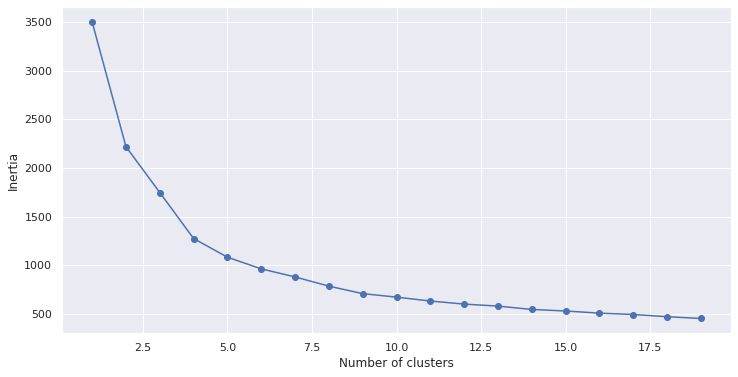

In [ ]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE_kpp})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Hence, it looks like our ideal `k=4`.

In [ ]:
preprocessor_km = Pipeline([("scaler", StandardScaler())])
clusterer_km = Pipeline([("kmeans", KMeans(n_clusters=4, init="k-means++"))])
pipe_km = Pipeline([("preprocessor", preprocessor_km), ("clusterer", clusterer_km)])

np.random.seed(42)
pipe_km.fit(numeric_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('clusterer',
                 Pipeline(steps=[('kmeans', KMeans(n_clusters=4))]))])

In [ ]:
numeric_data['kmean_labels'] = pipe_km["clusterer"]["kmeans"].labels_

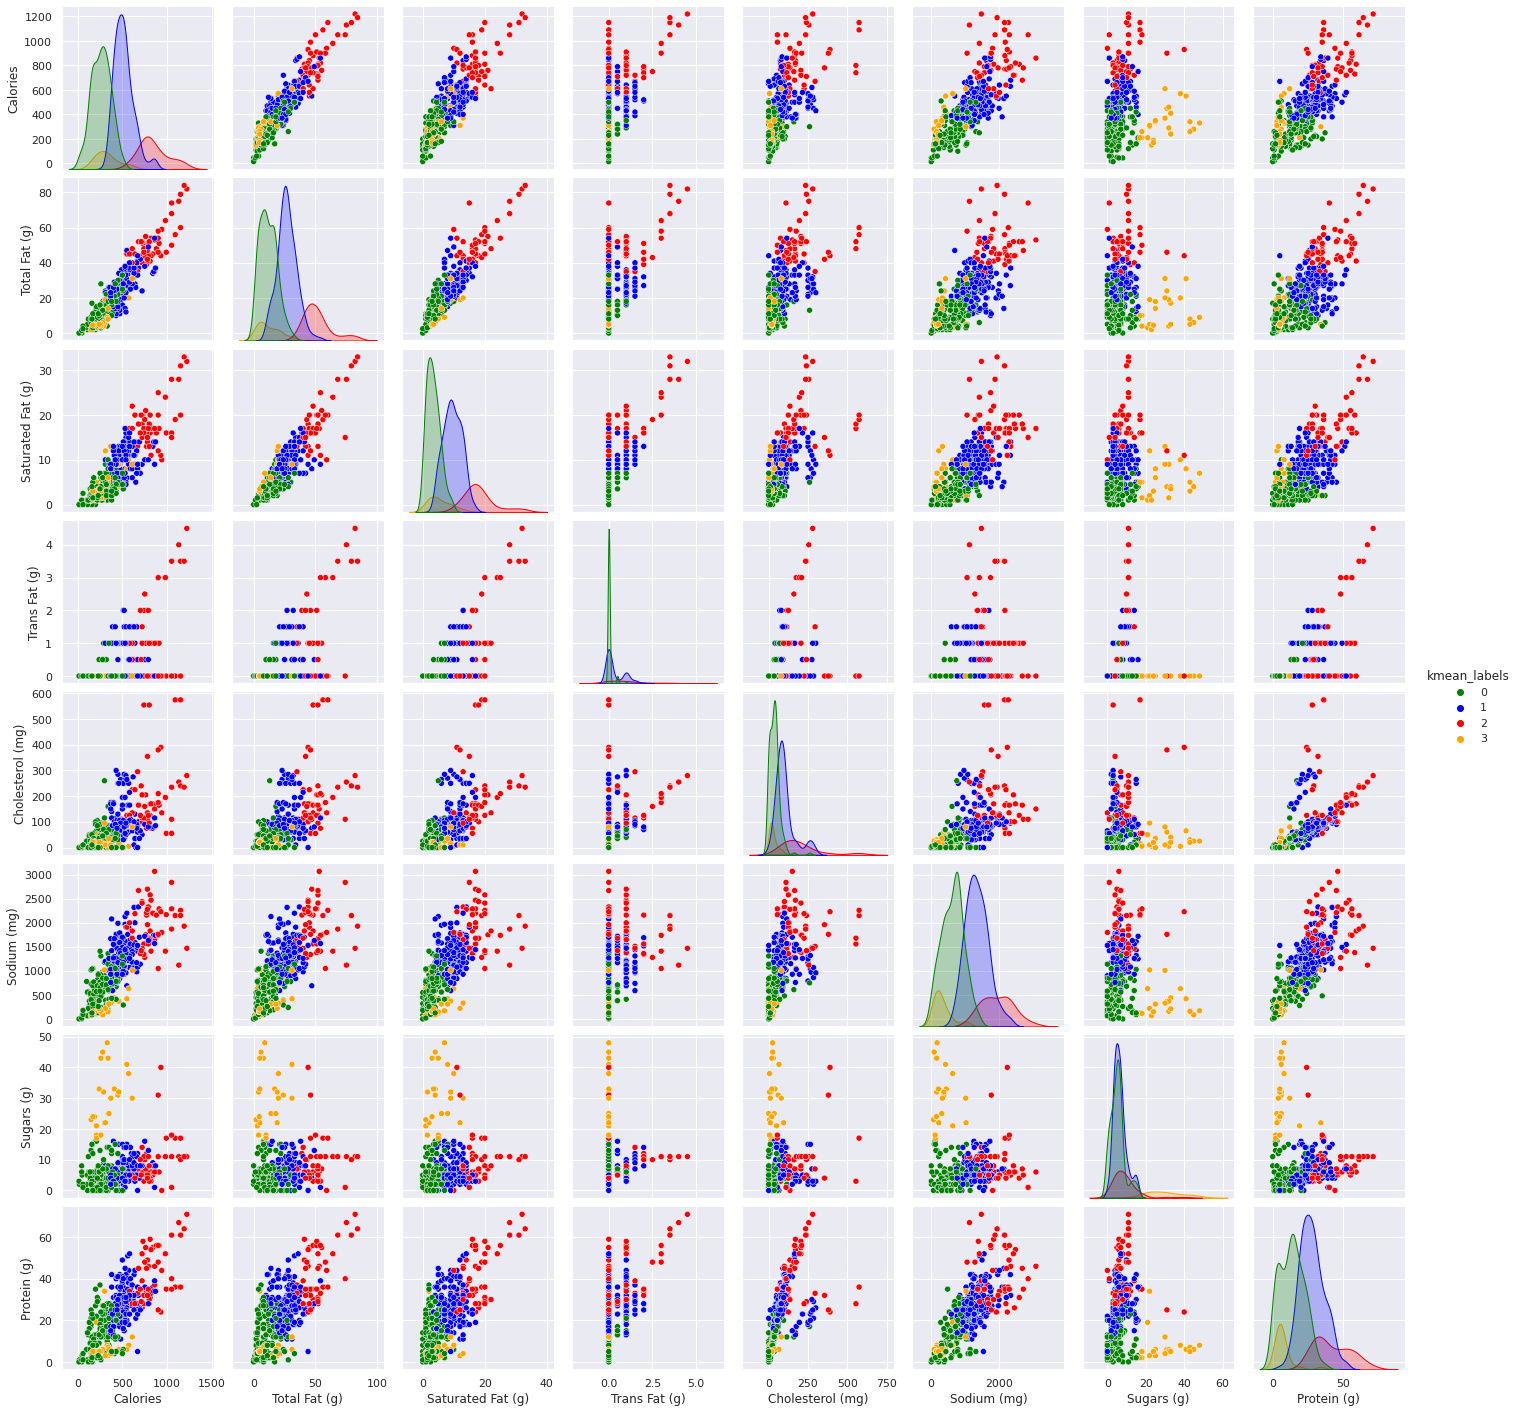

In [ ]:
sb.set()
sb.pairplot(numeric_data, hue='kmean_labels', palette=['green','blue','red','orange'])

From our k-means clustering, we get four clusters: Green, Blue, Orange, Red.

Just from the pairplot, we can roughly see that: 
* Red are the most unhealthy items, high in calories, fat, cholesterol , sodium and protein. They are generally low in sugar however, suggesting that these are savoury dishes not desserts.
* Orange represents the unhealthy desserts. They are low in most nutritional metrics, but have the highest sugar content.
* Blue represents food with the "mid-tier" level of healthiness. 
* Green looks to be the healthiest food, low in all nutritional metrics. However, it is to be noted they are also low in protein which is a nutrient there is better to have more of. Comparing this with green suggests that fast foods that are high in protein tend to still be "unhealthy" because of high levels of other nutrients.

Just to confirm, let's take a look at the items our blue and green clusters:


In [ ]:
clustered_data = numeric_data.copy()

In [ ]:
clustered_data['Item'] = merged_data['Item']
clustered_data['Category'] = merged_data['Category']
clustered_data['Restaurant'] = merged_data['Restaurant']

Our red cluster does turn out to be the big, unhealthy items like the Triple Whopper sandwich from Burger King.

In [ ]:
clustered_data[clustered_data['kmean_labels']==2]['Item']

40     Chicken & Bacon Ranch (with Grilled Chicken) o...
41     Chicken & Bacon Ranch (with Rotiserrie-Style C...
44                Meatball Marinara on Tomato Basil Wrap
48                    Spicy Italian on Tomato Basil Wrap
52                                  Tuna on Spinach Wrap
55     Baja Chicken & Bacon (with Rotisserie-Style Ch...
56     "CALI FRESH" Steak on Spinach Wrap (with Slice...
57     "CALI FRESH" Turkey on Spinach Wrap (with Smas...
58     "CALI FRESH" Steak on Spinach Wrap (with Smash...
59     "CALI FRESH" Turkey on Spinach Wrap(with Slice...
60                 Big Hot Pastrami on Tomato Basil Wrap
66                        Pizza Sub on Tomato Basil Wrap
67                       Steak Club on Tomato Basil Wrap
68                  Turkey Italiano on Tomato Basil Wrap
123         Chicken & Bacon Ranch (with Grilled Chicken)
124    Chicken & Bacon Ranch (with Rotisserie-Style C...
131                                        Spicy Italian
137    Baja Chicken & Bacon (wi

Our orange cluster does turn out to be the desserts:

In [ ]:
clustered_data[clustered_data['kmean_labels']==3]['Item']

101                 Sweet Onion Chicken Teriyaki
134                 Sweet Onion Chicken Teriyaki
174                               Chocolate Chip
177                     White Chip Macadamia Nut
180                                Cinnamon Roll
182                       Muffin, Apple Cinnamon
183                      Muffin, Blueberry Crumb
184                     Muffin, Double Chocolate
228                               Cinnamon Melts
229                        Fruit & Maple Oatmeal
230    Fruit & Maple Oatmeal without Brown Sugar
290                      Fruit 'n Yogurt Parfait
295                             Hot Fudge Sundae
296                           Hot Caramel Sundae
297                            Strawberry Sundae
358                              Dutch Apple Pie
359                         HERSHEY'S Sundae Pie
360                           Pie made with TWIX
361                       OREO Cookie Cheesecake
362                              Soft Serve Cone
363                 

But the red, orange clusters seem to overlap each other in just too many categories, and we can't be exactly sure what they represent. Hence, let's try to reduce the dimensionality of our data with PCA.

### 2. K-Means++ with PCA

In [ ]:
preprocessor_km_pca = Pipeline([("scaler", StandardScaler()), ("PCA", PCA(n_components=2))])
clusterer_km_pca = Pipeline([("kmeans", KMeans(n_clusters=4, init="k-means++"))])
pipe_km_pca = Pipeline([("preprocessor", preprocessor_km_pca), ("clusterer", clusterer_km_pca)])

In [ ]:
numeric_data_pca = merged_data.drop(['Item','Category','Restaurant','Meal Type', 'Carbohydrates (g)', 'Dietary Fiber (g)', 'Serving Size (g)'], axis=1)

In [ ]:
pipe_km_pca.fit(numeric_data_pca)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('PCA', PCA(n_components=2))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans', KMeans(n_clusters=4))]))])

In [ ]:
pca_data = pipe_km_pca["preprocessor"].transform(numeric_data_pca)
pca_labels = pipe_km_pca["clusterer"]["kmeans"].labels_

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

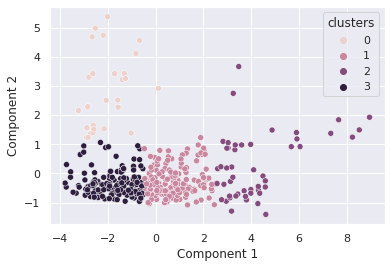

In [ ]:
pca_df = pd.DataFrame(pca_data, columns=["Component 1","Component 2"])
pca_df["clusters"] = pca_labels
sb.scatterplot("Component 1", "Component 2", data=pca_df, hue = "clusters")

So with PCA, the clusters become more clear. What are they exactly?

In [ ]:
clustered_data_pca = numeric_data_pca.copy()

In [ ]:
clustered_data_pca['Item'] = merged_data['Item']
clustered_data_pca['Category'] = merged_data['Category']
clustered_data_pca['Restaurant'] = merged_data['Restaurant']

In [ ]:
clustered_data_pca['kmean_labels'] = pca_labels

In [ ]:
clustered_data_pca[clustered_data_pca['kmean_labels']==0][['Restaurant', 'Item']]

,Restaurant,Item
101,Subway,Sweet Onion Chicken Teriyaki
134,Subway,Sweet Onion Chicken Teriyaki
174,Subway,Chocolate Chip
175,Subway,Oatmeal Raisin
176,Subway,Raspberry Cheesecake**
177,Subway,White Chip Macadamia Nut
180,Subway,Cinnamon Roll
182,Subway,"Muffin, Apple Cinnamon"
183,Subway,"Muffin, Blueberry Crumb"
184,Subway,"Muffin, Double Chocolate"


In [ ]:
clustered_data_pca[clustered_data_pca['kmean_labels']==1][['Restaurant', 'Item']]

,Restaurant,Item
3,Subway,"6"" Chicken & Bacon Ranch (with Grilled Chicken)"
4,Subway,"6"" Chicken & Bacon Ranch (with Rotisserie-Styl..."
7,Subway,"6"" Meatball Marinara"
11,Subway,"6"" Spicy Italian"
17,Subway,"6"" Baja Steak & Jack"
...,...,...
375,Burger King,"Ham, Egg, & Cheese Biscuit"
376,Burger King,"Sausage, Egg, & Cheese Biscuit"
377,Burger King,"Bacon, Egg & Cheese Biscuit"
379,Burger King,Breakfast Burrito Jr.


In [ ]:
clustered_data_pca[clustered_data_pca['kmean_labels']==2][['Restaurant', 'Item']]

,Restaurant,Item
40,Subway,Chicken & Bacon Ranch (with Grilled Chicken) o...
41,Subway,Chicken & Bacon Ranch (with Rotiserrie-Style C...
44,Subway,Meatball Marinara on Tomato Basil Wrap
48,Subway,Spicy Italian on Tomato Basil Wrap
55,Subway,Baja Chicken & Bacon (with Rotisserie-Style Ch...
56,Subway,"""CALI FRESH"" Steak on Spinach Wrap (with Slice..."
57,Subway,"""CALI FRESH"" Turkey on Spinach Wrap (with Smas..."
58,Subway,"""CALI FRESH"" Steak on Spinach Wrap (with Smash..."
59,Subway,"""CALI FRESH"" Turkey on Spinach Wrap(with Slice..."
60,Subway,Big Hot Pastrami on Tomato Basil Wrap


In [ ]:
clustered_data_pca[clustered_data_pca['kmean_labels']==3][['Restaurant', 'Item']]

,Restaurant,Item
0,Subway,"6"" All-American Club"
1,Subway,"6"" Black Forest Ham"
2,Subway,"6"" Buffalo Chicken (with Grilled Chicken)"
5,Subway,"6"" Cold Cut Combo"
6,Subway,"6"" Italian BMT®"
...,...,...
378,Burger King,Sausage Biscuit
384,Burger King,Hash Browns - small
385,Burger King,Hash Browns - medium
387,Burger King,French Toast Sticks (3 piece)


Other than observing trends, we can look at how each individual column (nutritional metric) affects components 1 and 2. The closer the value is to 1, the more each nutritional metric influences the component.

In [ ]:
print(abs(pipe_km_pca["preprocessor"]["PCA"].components_))
print(numeric_data_pca.columns)

[[0.42260232 0.42003919 0.42057797 0.28462506 0.32149773 0.37309333
  0.00146259 0.38015199]
 [0.09188122 0.02886971 0.10018792 0.2192388  0.01051639 0.25441118
  0.91989304 0.14690907]]
Index(['Calories', 'Total Fat (g)', 'Saturated Fat (g)', 'Trans Fat (g)',
       'Cholesterol (mg)', 'Sodium (mg)', 'Sugars (g)', 'Protein (g)'],
      dtype='object')


Roughly, it seems that like before, cluster 2 are the high caloric unhealthy foods, while cluster 0 are the high sugar foods like desserts.

We can see that for the two PCA components that we have generated:
* component 1 can be seen as the 'density factor', as most columns are somewhat equally weighted for that component. So the higher the component 1, the more heavy of a meal it would be;
* component 2 can be seen as the 'sugar' factor, where the higher the component 2, the higher the amount of sugar.

**Visually, clusters 1 and 3 can still be seen to be one big cluster. The two clusters can then be seen as  the foods that have higher and lower density factor than the average, which falls at `Component 1 = 0`**. 

Since the Dessert cluster is a category that we already know of, how about we repeat the process, but only for the foods that fall under `Meal Type == Main`?

### 3. K-Means++ with PCA on Mains

As with before, let's figure out the ideal `k` through the Elbow Method:

In [ ]:
SSE_pca_main = []
for cluster in range(1,20):
    preprocessor_main = Pipeline([("scaler", StandardScaler())])
    clusterer_main = Pipeline([("kmeans", KMeans(n_clusters=cluster, init="k-means++"))])
    pipe_main = Pipeline([("preprocessor", preprocessor_main), ("clusterer", clusterer_main)])
    pipe_main.fit(numeric_data)
    SSE_pca_main.append(pipe_main["clusterer"]["kmeans"].inertia_)

Text(0, 0.5, 'Inertia')

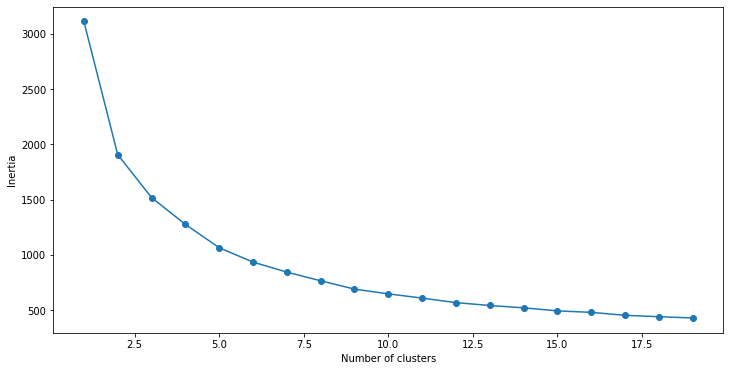

In [ ]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE_pca_main})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

And we get the elbow at `k=4` as well.

In [ ]:
preprocessor_main = Pipeline([("scaler", StandardScaler()), ("PCA", PCA(n_components=2))])
clusterer_main = Pipeline([("kmeans", KMeans(n_clusters=4, init="k-means++"))])
pipe_main = Pipeline([("preprocessor", preprocessor_main), ("clusterer", clusterer_main)])

In [ ]:
numeric_data_pca_main = merged_data[merged_data['Meal Type']=='Mains'].drop(['Item','Category','Restaurant','Meal Type', 'Carbohydrates (g)', 'Dietary Fiber (g)', 'Serving Size (g)'], axis=1)

In [ ]:
pipe_main.fit(numeric_data_pca_main)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('PCA', PCA(n_components=2))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans', KMeans(n_clusters=4))]))])

In [ ]:
pca_data_main = pipe_main["preprocessor"].transform(numeric_data_pca_main)
pca_labels_main = pipe_main["clusterer"]["kmeans"].labels_

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

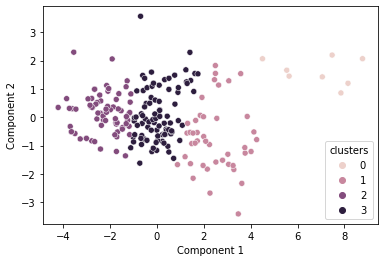

In [ ]:
pca_df_main = pd.DataFrame(pca_data_main, columns=["Component 1","Component 2"])
pca_df_main["clusters"] = pca_labels_main
sb.scatterplot("Component 1", "Component 2", data=pca_df_main, hue = "clusters")

Immediately, we can see that cluster 0 is significantly distinct from the other clusters.

In [ ]:
clustered_data_main = numeric_data_pca_main.copy()
clustered_data_main['kmean_labels'] = pca_labels_main

clustered_data_main['Item'] = merged_data[merged_data['Meal Type']=='Mains']['Item']
clustered_data_main['Category'] = merged_data[merged_data['Meal Type']=='Mains']['Category']
clustered_data_main['Restaurant'] = merged_data[merged_data['Meal Type']=='Mains']['Restaurant']

In [ ]:
clustered_data_main[clustered_data_main['kmean_labels']==0][['Restaurant', 'Item']]

,Restaurant,Item
301,Burger King,DOUBLE WHOPPER Sandwich
302,Burger King,DOUBLE WHOPPER Sandwich with Cheese
303,Burger King,TRIPLE WHOPPER Sandwich
304,Burger King,TRIPLE WHOPPER Sandwich with Cheese
306,Burger King,BACON KING Sandwich
307,Burger King,Cheddar BACON KING Sandwich
309,Burger King,Double Quarter Pound KING Sandwich
311,Burger King,Double STACKER KING


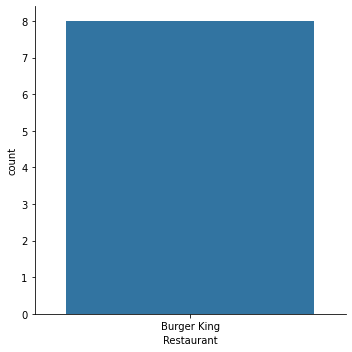

In [ ]:
y=clustered_data_main[clustered_data_main['kmean_labels']==0]
sb.catplot(data=y, x="Restaurant", kind="count")

In [ ]:
clustered_data_main[clustered_data_main['kmean_labels']==1][['Restaurant', 'Item']]

,Restaurant,Item
37,Subway,All-American Club on Spinach Wrap
40,Subway,Chicken & Bacon Ranch (with Grilled Chicken) o...
41,Subway,Chicken & Bacon Ranch (with Rotiserrie-Style C...
43,Subway,Italian BMT® on Tomato Basil Wrap
44,Subway,Meatball Marinara on Tomato Basil Wrap
48,Subway,Spicy Italian on Tomato Basil Wrap
52,Subway,Tuna on Spinach Wrap
54,Subway,Baja Steak & Jack on Tomato Basil Wrap
55,Subway,Baja Chicken & Bacon (with Rotisserie-Style Ch...
56,Subway,"""CALI FRESH"" Steak on Spinach Wrap (with Slice..."


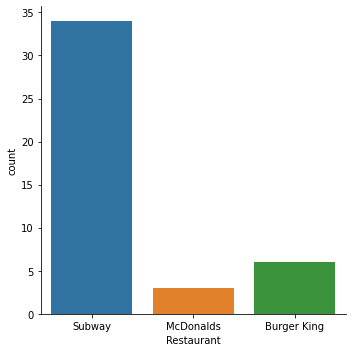

In [ ]:
z=clustered_data_main[clustered_data_main['kmean_labels']==1]
sb.catplot(data=z, x="Restaurant", kind="count")

In [ ]:
clustered_data_main[clustered_data_main['kmean_labels']==2][['Restaurant', 'Item']]

,Restaurant,Item
0,Subway,"6"" All-American Club"
1,Subway,"6"" Black Forest Ham"
2,Subway,"6"" Buffalo Chicken (with Grilled Chicken)"
5,Subway,"6"" Cold Cut Combo"
6,Subway,"6"" Italian BMT®"
...,...,...
353,Burger King,Kids Oatmeal
354,Burger King,Chicken Nuggets- 4pc
355,Burger King,Chicken Nuggets- 6pc
356,Burger King,Hamburger


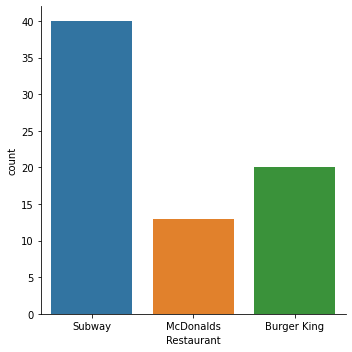

In [ ]:
a=clustered_data_main[clustered_data_main['kmean_labels']==2]
sb.catplot(data=a, x="Restaurant", kind="count")

In [ ]:
clustered_data_main[clustered_data_main['kmean_labels']==3][['Restaurant', 'Item']]

,Restaurant,Item
3,Subway,"6"" Chicken & Bacon Ranch (with Grilled Chicken)"
4,Subway,"6"" Chicken & Bacon Ranch (with Rotisserie-Styl..."
11,Subway,"6"" Spicy Italian"
18,Subway,"6"" Baja Chicken & Bacon (with Rotisserie-Style..."
19,Subway,"6"" ""CALI FRESH"" Steak (with Smashed Avocado)"
...,...,...
320,Burger King,Crispy Chicken Sandwich
321,Burger King,Spicy Crispy Chicken Sandwich
322,Burger King,Original Chicken Sandwich
324,Burger King,BBQ Bacon Crispy Chicken Sandwich


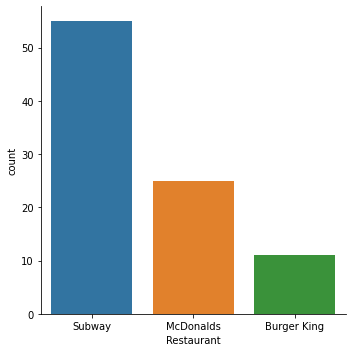

In [ ]:
b=clustered_data_main[clustered_data_main['kmean_labels']==3]
sb.catplot(data=b, x="Restaurant", kind="count")

Once again, we identify which columns (nutritional metrics) influence each component the most, as follows:

In [ ]:
print(abs(pipe_main["preprocessor"]["PCA"].components_))
print(numeric_data_pca_main.columns)

[[0.40012829 0.39281447 0.40952974 0.30493037 0.39509702 0.31161638
  0.16537362 0.37992386]
 [0.08226721 0.11376681 0.01203839 0.46073359 0.02991268 0.46257218
  0.73825523 0.08933243]]
Index(['Calories', 'Total Fat (g)', 'Saturated Fat (g)', 'Trans Fat (g)',
       'Cholesterol (mg)', 'Sodium (mg)', 'Sugars (g)', 'Protein (g)'],
      dtype='object')


With the data more spread out after choosing only mains, and our PCA components having roughly the same decomposition, we can see that even amongst the 'unhealthy' cluster identified earlier on, the Burger King's burgers stands out significantly wtihin that cluster, and are chosen to be a separate cluster in this analysis.

Hence, we can conclude that even amongst the 'worst' fast food items amongst the three fast food restaurants in our analysis, Burger Kings' big burgers like the Triple Whopper still end up significantly 'worse' than the other bad offenders.

**We do note that Component 1 may not necessarily be 'worse' as it takes into account most columns, and most columns will increase in magnitude as the food item's calorie count increases (as there is _more_ food in that item). Hence Component 1 may merely be a measure of the amount of food in one item. Nevertheless, we would still go with it being a measure of 'worseness' as over-eating in fast food places is one of the reasons why fast-food is unhealthy as it is.**

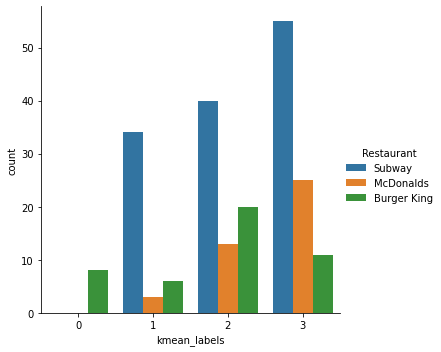

In [ ]:
sb.catplot(data=clustered_data_main, x="kmean_labels", kind="count", hue="Restaurant")

Considering the PCA components and observing the trends, we can conclude that for mains, Subway has the largest healthy selection, and most of its items are in clusters 2 or 3. McDonalds also has relatively healthier mains, as the distribution of its mains follows the same pattern (mostly in clusters 2 and 3). Like we've observed before even in the EDA, Burger King has a large and more even spread of healthy and unhealthy foods, Its has the most items under cluster 2, which is moderately unhealthy. Overall, it does seem that Subway and McDonalds may offer comparatively healthier options for fast food.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cd1c4af-daef-4005-958a-27a380c5f533' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>